In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#os — to read files and directory structure
#numpy — for some matrix math outside of TensorFlow
#matplotlib.pyplot — to plot the graph and display images in our training and validation data

import os
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [8]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 11s 0us/step


In [13]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print


FIND : format incorrect de paramètre


In [15]:
#Nous allons maintenant attribuer des variables avec le chemin de fichier approprié pour les ensembles de formation et de validation.

base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [17]:
#Let's look at how many cats and dogs images we have in our training and validation directory

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [19]:
#Définition des paramètres du modèle
#nous configurerons des variables qui seront utilisées plus tard lors du prétraitement de notre ensemble de données et de la formation de notre réseau.

BATCH_SIZE = 100  # Nombre d'exemples de formation à traiter avant de mettre à jour les variables de nos modèles
IMG_SHAPE  = 150  # Nos données de formation sont constituées d'images d'une largeur de 150 pixels et d'une hauteur de 150 pixels

In [20]:
#Les images doivent être formatées en tenseurs à virgule flottante prétraités de manière appropriée avant d'être introduites dans le réseau.
#Les étapes impliquées dans la préparation de ces images sont :

#Lire les images du disque
#Décoder le contenu de ces images et le convertir au format de grille approprié selon leur contenu RVB
#Convertissez-les en tenseurs à virgule flottante
#Redimensionnez les tenseurs de valeurs comprises entre 0 et 255 vers des valeurs comprises entre 0 et 1
#car les réseaux de neurones préfèrent traiter de petites valeurs d'entrée.

train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [24]:
#Après avoir défini nos générateurs pour les images de formation et de validation, la méthode flow_from_directory chargera les 
#images à partir du disque, appliquera la redimensionnement et les redimensionnera en utilisant une seule ligne de code.

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, #batch size = on lit 100 images à la fois
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150 -> redimensionne)
                                                           class_mode='binary') #car seulement deux classes dog et cat

Found 2000 images belonging to 2 classes.


In [25]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150 -> redimensionne)
                                                              class_mode='binary')  #car seulement deux classes dog et cat

Found 1000 images belonging to 2 classes.


In [27]:
#VISUALISATION des images de formation
#Nous pouvons visualiser nos images de formation en récupérant un lot d'images du générateur de formation
#puis en traçant quelques-unes d'entre elles à l'aide de matplotlib.

sample_training_images, _ = next(train_data_gen)

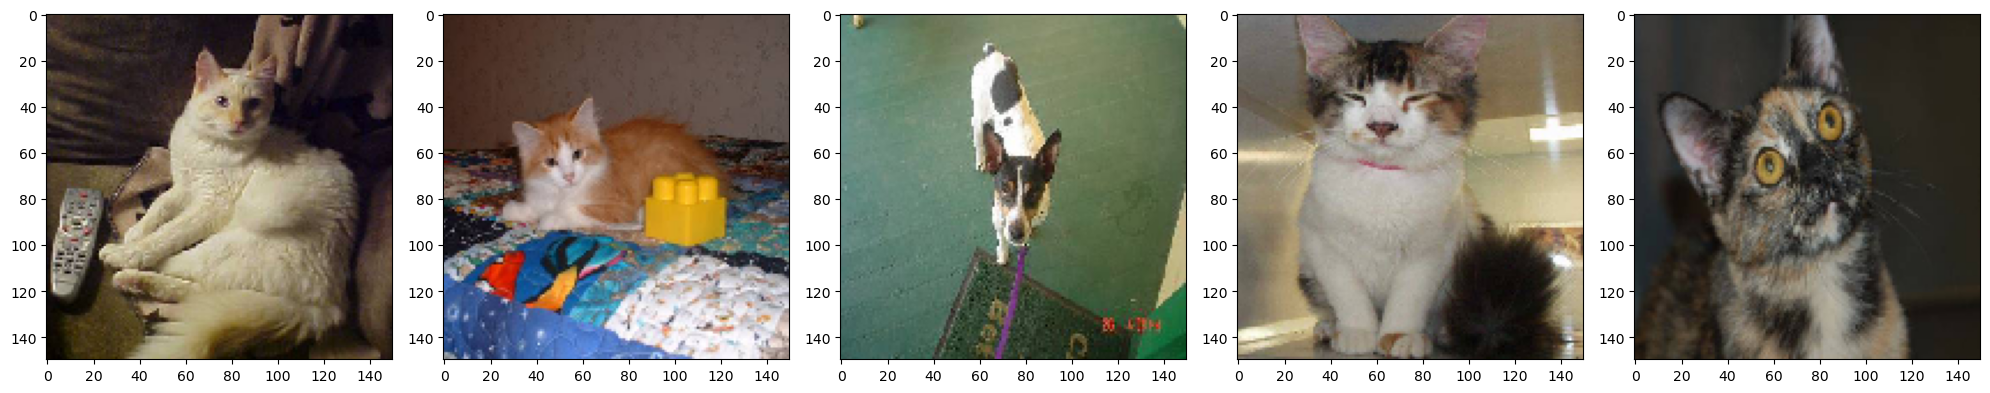

In [28]:
#La fonction suivante renvoie un lot de l'ensemble de données. Un lot est un 
#tuple de (plusieurs images, plusieurs étiquettes). Pour l'instant, nous supprimons les 
#étiquettes parce que nous voulons juste regarder les images.

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4

In [29]:
#CREATION DU MODELE 

#Il comporte quatre bloc de convolution et max pooling
#Et une section finale dans laquelle nous applatissons le resulat de la convolution
# Les resulats seront transmis à un dense layer de 512 neuronne et enfin produit 2 valeur, la distribution de la probabilité chien/chat
#Le modèle générera des probabilités de classe pour deux classes – chiens et chats – en utilisant softmax.

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])


In [30]:
#COMPILER LE MODELE
#Comme d'habitude, nous utiliserons l'optimiseur Adam.
#Puisque nous produisons une catégorisation softmax, nous utiliserons sparse_categorical_crossentropy comme fonction de perte.
#Nous aimerions également examiner la précision de la formation et de la validation à chaque époque au fur et à mesure que 
#nous formons notre réseau, nous transmettons donc l'argument des métriques.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
#R2SUM2 DU MODELE
#Examinons toutes les couches de notre réseau en utilisant la méthode récapitulative.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
#ENTRAINER LE MODELE
#Il est temps de former notre réseau.
#Puisque nos lots proviennent d'un générateur (ImageDataGenerator), nous utiliserons fit_generator au lieu de fit.

EPOCHS = 100 #plus ce nombre augmente et plus la precision augmente
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

In [ ]:
#On peut voir au dessus qu'on atteint une precision de 100% sur le dataset d'entrainement mais la précision de validation s'arrete à 76%
#C'est une indication claire de SURAPPRENTISSAGE

#VISUALISER LES RESULAT DE L'ENTRAINEMENT
#Nous allons maintenant visualiser les résultats que nous obtenons après avoir formé notre réseau.
#Alors que la precision 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

#On peut voir qu'apres 20 EPOCHS la précision de la validation a commencé a stagner
#Alors que la precision a grimpé jusqu'a 100%

